# Basics of molecular graph

This tutorial includes following fundamental operations of molecular graph.

- Concept of molecular object
- Iterate over graph elements
- Count atom nodes and bond edges
- Neighbors/adjacencies/incidences
- Edit molecular graph
- Subgraph view

In [1]:
using Pkg
Pkg.activate("..")
using MolecularGraph

 Activating environment at `~/Repository/MolecularGraph.jl_notebook/Project.toml`


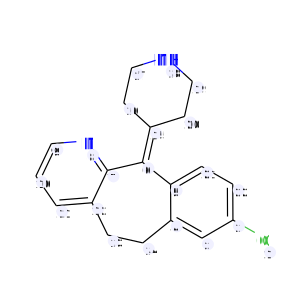

In [2]:
# Demo molecule with atom indices
mol = smilestomol("Clc4cc2c(C(/c1ncccc1CC2)=C3/CCNCC3)cc4")
canvas = SvgCanvas()
draw2d!(canvas, mol)
drawatomindex!(canvas, mol)
molsvg = tosvg(canvas, 300, 300)
display("image/svg+xml",  molsvg)

## Concept of molecule object

`GraphMol{Atom,Bond}` is a general purpose molecule type often used in MolecularGraph.jl. You can find the definition of it in `src/model/molgraph.jl`

```julia
struct GraphMol{A<:Atom,B<:Bond} <: OrderedGraph
    neighbormap::Vector{Dict{Int,Int}}
    edges::Vector{Tuple{Int,Int}}
    nodeattrs::Vector{A}
    edgeattrs::Vector{B}
    cache::Dict{Symbol,Any}
    attributes::Dict{Symbol,Any}
end
```

GraphMol is a simple graph model with molecule attributes. The graph is represented by `neighbormap` field (size N vector of adjacency dict {edge => node}) and `edges` field (size E vector of tuples (node1, node2)), where N is the number of nodes and E is the number of edges. This model assumes node and edge indices are consecutive, so implicitly indices of `neighbormap`and `edges` vectors correspond to node and edge indices, respectively.

`nodeattrs` field is a size N vector of node attibute objects that have subtype of `Atom`. `Atom` is typically immutable and have atom property values such as atom symbol, charge number, mass number, and etc.

`edgeattrs` fiels is a size E vector of edge attiblute objects that have subtype of `Bond`. `Bond` is also typically immutable and have bond property values such as bond order number and stereochemistry flags.

`cache` is caches of calculated descriptors described later.
`attributes` is attributes of the molecule itself. Typically, SDFile optional fields like `> <compound_name>` will be stored in this field.

## Iterate over graph elements

Calling `GraphMol.nodeattrs` and `GraphMol.edgeattrs` directly is not recommended. Use `nodeattrs(mol)` and `edgeattrs(mol)` interfaces to iterate over elements.

Most of graph related functions are in `Graph` submodule. You can write `using MolecularGraph.Graph` to call these functions conveniently.

In [3]:
using MolecularGraph.Graph

println("Atoms:")
for (i, atom) in enumerate(nodeattrs(mol))
    print("($(i), $(atom.symbol)), ")
end
println()
println("Bonds:")
for (i, bond) in enumerate(edgeattrs(mol))
    print("($(i), $(bond.order)), ")
end

Atoms:
(1, Cl), (2, C), (3, C), (4, C), (5, C), (6, C), (7, C), (8, N), (9, C), (10, C), (11, C), (12, C), (13, C), (14, C), (15, C), (16, C), (17, C), (18, N), (19, C), (20, C), (21, C), (22, C), 
Bonds:
(1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 2), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 2), (24, 1), (25, 2), 

## Count atom nodes and bond edges

`Graph.nodecount` and `Graph.edgecount` counts the number of graph elements. Note that these do not include atoms not described in the graph (e.g. Implicit hydrogen).

In [4]:
ncnt = nodecount(mol)
ecnt = edgecount(mol)
println("Nodes: $(ncnt)")
println("Edges: $(ecnt)")

Nodes: 22
Edges: 25


##  Neighbors/adjacencies/incidences

`neighbors(mol, atom1)` returns dict of (`edge` => `atom2`) that means `atom2` is connected to `atom1` through `edge`. This is just an aliase of `mol.neighbormap[atom1]` indeed.

`adjacencies(mol, atom1)` returns a set of adjacent (= connected by edge) nodes.  `incidences(mol, atom2)` returns a set of incident (= connecting) edges. These methods generate new sets, therefore are safe for destructive operations like `setdiff!` but a bit more costful than `neighbors`.

In [5]:
neighbors(mol, 2)

Dict{Int64,Int64} with 3 entries:
  25 => 22
  2  => 3
  1  => 1

In [6]:
adjacencies(mol, 2)

Set{Int64} with 3 elements:
  3
  22
  1

In [7]:
incidences(mol, 2)

Set{Int64} with 3 elements:
  25
  2
  1

## Edit molecular graph

In MolecularGraph.jl, methods to edit molecules manually are often less accessible intentionally. These method can change molecule objects unexpectedly and will cause serious adverce effect that can affect consistency and reproducibility of your analysis workflow.

In many cases, following alternative methods would suffice.

- Methods in `src/preprocessing.jl`for general cheminformatics operations (see Preprocessing tutorial)
    - `removehydrogens`/`addhydrogens` -> deal with implicit/explicit hydrogens
    - `extractlargestcomponent` -> desaltation and dehydration
    - Standardization of notation in protonation and resonance structure
- Extract substructures by `nodesubgraph` and `edgesubgraph` described below

### Graph topology

There are some methods that directly manipulate graph topology in the graph interface API (e.g. `addnode!`, `addedge!`, `unlinknodes` and `unlinkedges`), but are not recommended to use because insertion and deletion of graph elements are computationally expensive in our molecular graph model based on vectors.

### Attributes of graph elements

Note that types belongs to `Atom` and `Bond` are typically immutable. There are some methods to edit attributes like `setcharge(atom)` and `setorder(bond)` that actually do not change the objects themselves but return new Atom and Bond with attributes editted. 

`setnodeattr!(mol, i, atom)` and `setedgeattr!(mol, i, edge)` are interfaces to replace the attribute object at the position i of `mol.nodeattr`/`mol.edgeattr` by the new atom/edge.

Accordingly, code to edit an atom attribute would be like as shown below.

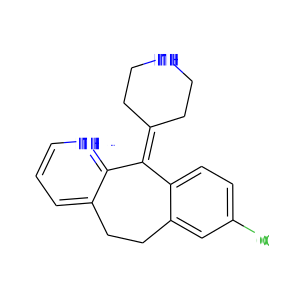

In [8]:
mol2 = clone(mol)  # I want to use the original mol later
newatom = setcharge(nodeattr(mol2, 8), 1)
setnodeattr!(mol2, 8, newatom)
molsvg = drawsvg(mol2, 300, 300)
display("image/svg+xml",  molsvg)

## Subgraph view

`SubgraphView` consists of the original graph, node set and edge set, and behaves as almost same as `GraphMol ` object that is substructure of the original graph derived from the node and edge sets.

`nodesubgraph(mol, nodeset)` returns `SubgraphView` object that represents node-induced substructure of `mol` induced from `nodeset`. `edgesubgraph(mol, edgeset)` returns edge-induced `SubgraphView` similarily.

As SubgraphView refers molecule attributes and calculated descriptors of the original molecule, many descriptor calculation methods (and even structure drawing) can be applied to it without problems.

In [9]:
subg = nodesubgraph(mol, Set(7:12))
ncnt = nodecount(subg)
ecnt = edgecount(subg)
adj7 = adjacencies(subg, 7)
println("Nodes: $(ncnt)")
println("Edges: $(ecnt)")
println("Adjacecies of atom 7: $(adj7)")

Nodes: 6
Edges: 6
Adjacecies of atom 7: Set([8, 12])


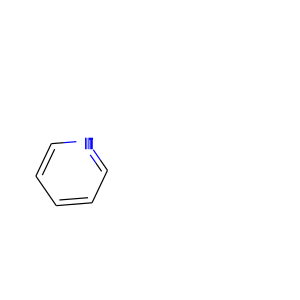

In [10]:
molsvg = drawsvg(subg, 300, 300)
display("image/svg+xml",  molsvg)

SubgraphView can be nested. But frequent subgraphing can affect performance.

If you want to mine subgraph space deeply, it is recommended to instanciate it as GraphMol by `graphmol(subg)`.

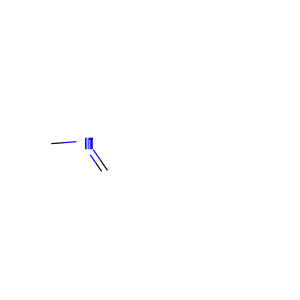

In [11]:
subgsubg = nodesubgraph(subg, Set(7:9))
molsvg = drawsvg(subgsubg, 300, 300)
display("image/svg+xml",  molsvg)

In [12]:
graphmol(subgsubg)

GraphMol{SmilesAtom,SmilesBond}([Dict(1 => 2), Dict(2 => 3,1 => 1), Dict(2 => 2)], [(1, 2), (2, 3)], SmilesAtom[SmilesAtom(:C, 0, 1, nothing, true, :unspecified), SmilesAtom(:N, 0, 1, nothing, true, :unspecified), SmilesAtom(:C, 0, 1, nothing, true, :unspecified)], SmilesBond[SmilesBond(2, false, :unspecified, :unspecified), SmilesBond(1, false, :unspecified, :unspecified)], Dict{Symbol,Any}(), Dict{Symbol,Any}())